In [374]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [375]:
df = yf.download('^NSEI', start='2015-01-01', end='2025-01-01')
df.head()

/tmp/ipython-input-611532065.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('^NSEI', start='2015-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,
2015-01-02,8395.450195,8410.599609,8288.700195,8288.700195,101900
2015-01-05,8378.400391,8445.599609,8363.900391,8407.950195,118200
2015-01-06,8127.350098,8327.849609,8111.350098,8325.299805,172800
2015-01-07,8102.100098,8151.200195,8065.450195,8118.649902,164100
2015-01-08,8234.599609,8243.500000,8167.299805,8191.399902,143800


In [376]:
df = df.reset_index()

In [377]:
df['return'] = df['Close'].pct_change().fillna(0)
df['volume_log'] = np.log1p(df['Volume'])
df['day_of_week'] = df['Date'].dt.dayofweek

In [378]:
df.describe()

Price,Date,Close,High,Low,Open,Volume,return,volume_log,day_of_week
Ticker,,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI,,,
count,2459,2459.000000,2459.000000,2459.000000,2459.000000,2.459000e+03,2459.000000,2459.000000,2459.000000
mean,2020-01-04 08:36:30.158601216,13506.704131,13578.560372,13431.631915,13516.667489,3.223233e+05,0.000476,12.403293,1.996747
min,2015-01-02 00:00:00,6970.600098,7034.200195,6825.799805,7023.649902,0.000000e+00,-0.129805,0.000000,0.000000
25%,2017-07-06 12:00:00,9347.000000,9423.325195,9299.875000,9375.750000,1.943000e+05,-0.004362,12.177164,1.000000
50%,2020-01-10 00:00:00,11515.200195,11573.000000,11451.250000,11531.599609,2.624000e+05,0.000665,12.477629,2.000000
75%,2022-07-02 12:00:00,17531.450195,17622.575195,17422.250000,17530.674805,3.843000e+05,0.006102,12.859181,3.000000
max,2024-12-31 00:00:00,26216.050781,26277.349609,26151.400391,26248.250000,1.811000e+06,0.087632,14.409390,4.000000
std,NaN,4967.729528,4986.944771,4946.175825,4968.505490,1.949277e+05,0.010476,1.454363,1.409888


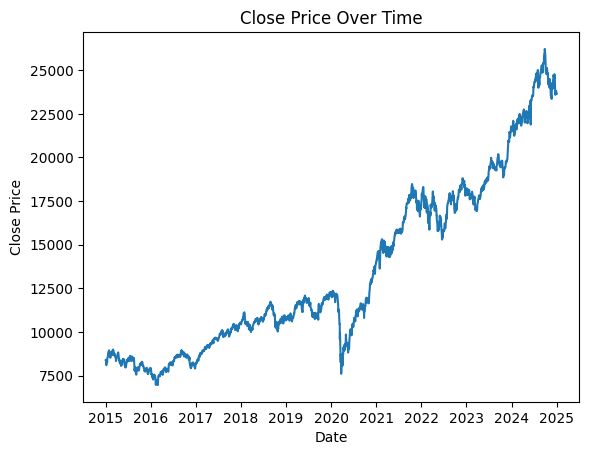

In [379]:
x=df['Date']
y=df['Close']
plt.plot(x,y)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Over Time')
plt.show()

In [380]:
df['MA_20'] = df['Close'].rolling(window=20).mean()

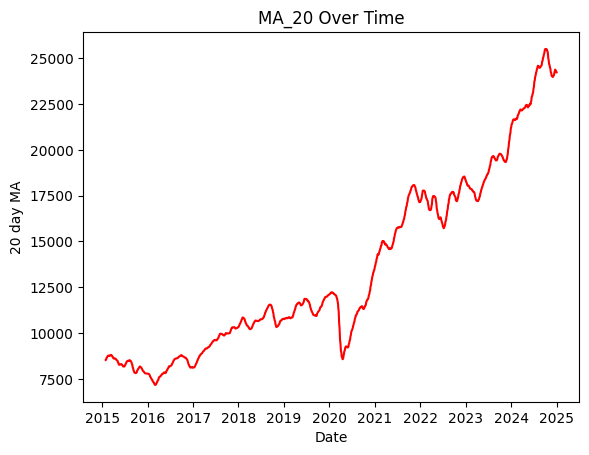

In [381]:
x=df['Date']
y=df['MA_20']
plt.plot(x,y, color='r')
plt.xlabel('Date')
plt.ylabel('20 day MA')
plt.title('MA_20 Over Time')
plt.show()

In [382]:
df.fillna(df.mean(), inplace=True)

In [383]:
features=['Open', 'High', 'Low', 'return', 'volume_log','MA_20']

In [384]:
x=df[features]
y=df['Close']

In [385]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [386]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.fit_transform(y_test.values.reshape(-1, 1))

In [387]:
import torch
import torch.nn as nn

In [388]:
x_tensor = torch.tensor(x_train_scaled, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)

In [389]:
n_units = 256
layers = 2
n_batch = 64
n_epochs = 100
learning_rate = 0.01
input_dim = x_tensor.shape[2]
sequence_len = x_tensor.shape[1]

In [390]:
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter

In [391]:
dataset = TensorDataset(x_tensor, y_tensor)
val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [392]:
train_loader = DataLoader(train_dataset, batch_size=n_batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=n_batch)

In [393]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, n_units, layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, n_units, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(n_units, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        out = self.fc(last_output)
        return out


In [394]:
model = LSTMModel(input_dim, n_units, layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [395]:
writer = SummaryWriter()

In [396]:
train_losses = []
val_losses = []
avg_train_loss=0
avg_val_loss=0

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            output = model(x_val)
            loss = criterion(output, y_val)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1/100 - Train Loss: 0.1488 - Val Loss: 0.0199
Epoch 11/100 - Train Loss: 0.0005 - Val Loss: 0.0008
Epoch 21/100 - Train Loss: 0.0009 - Val Loss: 0.0025
Epoch 31/100 - Train Loss: 0.0002 - Val Loss: 0.0003
Epoch 41/100 - Train Loss: 0.0006 - Val Loss: 0.0025
Epoch 51/100 - Train Loss: 0.0003 - Val Loss: 0.0008
Epoch 61/100 - Train Loss: 0.0015 - Val Loss: 0.0106
Epoch 71/100 - Train Loss: 0.0003 - Val Loss: 0.0003
Epoch 81/100 - Train Loss: 0.0002 - Val Loss: 0.0002
Epoch 91/100 - Train Loss: 0.0004 - Val Loss: 0.0006


In [397]:
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

In [398]:
from sklearn.metrics import r2_score

In [399]:
model.eval()
with torch.no_grad():
    y_pred_tensor = model(x_test_tensor).squeeze()
y_pred = y_pred_tensor.numpy()

r2 = r2_score(y_test_scaled, y_pred)
print(f"R2 Score: {r2:.4f}")

R2 Score: 0.9997


In [400]:
y_pred_scaled = np.array(y_pred)
y_actual_scaled = np.array(y_test_scaled)

preds = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
actuals = y_scaler.inverse_transform(y_actual_scaled.reshape(-1, 1))

In [420]:
result_df = pd.DataFrame({'Date': df.loc[x_test.index, 'Date'],'Actual_Close': actuals.flatten(),'Predicted_Close': preds.flatten()})
result_df.sort_values(by='Date', inplace=True)
result_df = result_df[['Date', 'Actual_Close', 'Predicted_Close']]
result_df.reset_index(drop=True, inplace=True)
result_df.head()

,Date,Actual_Close,Predicted_Close
0,2015-01-29,8952.349609,8857.625000
1,2015-02-09,8526.349609,8464.862305
2,2015-02-13,8805.500000,8713.643555
3,2015-03-09,8756.750000,8722.881836
4,2015-03-10,8712.049805,8656.917969


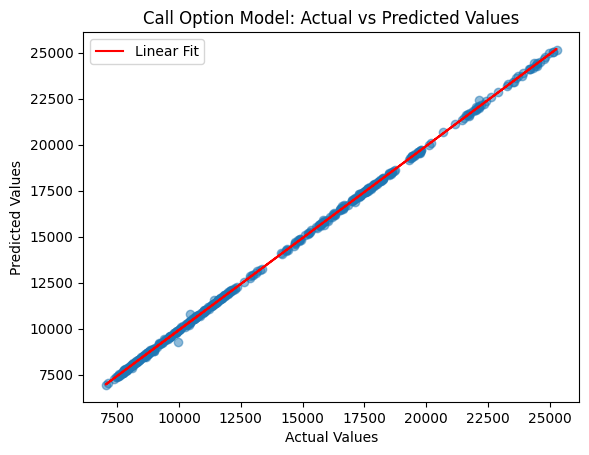

In [421]:
plt.scatter(actuals.flatten(), preds.flatten(), alpha=0.5)
plt.title('Call Option Model: Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

fit_line = np.polyfit(actuals.flatten(), preds.flatten(), 1)
fit_line_fn = np.poly1d(fit_line)
plt.plot(actuals.flatten(), fit_line_fn(actuals.flatten()), color='red', label='Linear Fit')

plt.legend()
plt.show()